# Model-data comparison: Example using the Parallel Ice Sheet Model

PISM includes an englacial layer tracing scheme [(Born and Robinson 2021)](https://doi.org/10.5194/tc-15-4539-2021) since its version 2.1 [(PISM docs)](https://www.pism.io/docs/manual/modeling-choices/dynamics/age.html)

This notebook shows how to make direct use of the AntADabase and the anta_database module for comparing a model run with PISM and IRH data. It is not meant to be very efficient, but descriptive, and people should be able to take parts of the code to implement it in there diagnostic routines.

# 2D Layer mismatch

## PISM output

This example is using output from a regional domain setup around Dome C, East Antarctica. Layers were traced to match the Cavitte et al. 2020 dataset.
Note that PISM time is in second since year 0, while the dated IRHs are in years before 1950. So one has to make sure that the ages match.
PISM outputs the 'isochronal_layer_thickness' variable, which needs to be converted to isochronal depth. Then we select the layer of interest. 
Here is with xarray, but one can use netCDF4:

In [1]:
import xarray as xr
import numpy as np

pism_out = xr.open_dataset('/home/anthe/documents/data/isochrones/pism_output_example/edc_pism_output.nc', engine='netcdf4', decode_times=False).squeeze()
pism_out['isochronal_layer_depth'] = pism_out['isochronal_layer_thickness'].copy() # creating a new variable for layer depths of same shape of layer thicknesses

for i in range(pism_out.deposition_time.size):
    pism_out['isochronal_layer_depth'][:,:,i] = pism_out.isochronal_layer_thickness.isel(deposition_time=slice(i, None)).sum(dim='deposition_time').values

age = 38000
age_offset = -1950
age_seconds = -(age+age_offset)*3600*24*365
pism_layer = pism_out.isochronal_layer_depth.sel(deposition_time=age_seconds).values.flatten()
X_pism, Y_pism = np.meshgrid(pism_out.x, pism_out.y)
pism_points = np.column_stack((X_pism.flatten(), Y_pism.flatten()))

## Query the AntADatabase

One can query the Database and fetch the files containing the data to compare with:

In [2]:
from anta_database import Database

db = Database('/home/anthe/documents/data/isochrones/AntADatabase/')
db.filter_out(flight_id=['%RAID%', '2H%', '2V%', 'HR%', 'BH%', 'H4%'])
query = db.query(dataset='Cavitte_2020', age='38100') # compare with 38.1 ka layer

irh_files = db.get_files()

## Interpolate PISM

Next we loop through the IRH flight line files, interpolate the PISM isochronal layer depth on each flight line coordinates and compute the difference in depth. We concatenate the results in a DataFrame for plotting. Here we show both with xarray, which is provides a convenient interface with the data, and with h5py, which is much faster:

### xarray

In [3]:
from scipy.interpolate import griddata
import pandas as pd

all_psx = []
all_psy = []
all_depth_diff = []

for f in irh_files:
    irh = xr.open_dataset(f, engine='h5netcdf')
    irh_layer = irh.IRH_DEPTH.sel(IRH_AGE=int(query['age'][0]))
    fl_line_xy = np.column_stack((irh.PSX, irh.PSY))
    pism_depth_interp = griddata(pism_points, pism_layer, fl_line_xy, method='linear')
    depth_diff = pism_depth_interp - irh_layer

    all_psx.extend(irh.PSX.values)
    all_psy.extend(irh.PSY.values)
    all_depth_diff.extend(depth_diff)

### h5py

In [4]:
import h5py

all_psx = []
all_psy = []
all_depth_diff = []

for f in irh_files:
    with h5py.File(f, 'r') as irh:
        irh_values = irh['IRH_AGE'][:]
        irh_index = np.where(irh_values == int(query['age'][0]))[0]
        irh_index = irh_index[0]
        irh_layer = irh['IRH_DEPTH'][:, irh_index]

        fl_line_xy = np.column_stack((irh['PSX'][:], irh['PSY'][:]))
        pism_depth_interp = griddata(pism_points, pism_layer, fl_line_xy, method='linear')
        depth_diff = pism_depth_interp - irh_layer

        all_psx.extend(irh['PSX'][:])
        all_psy.extend(irh['PSY'][:])
        all_depth_diff.extend(depth_diff)

## Plotting

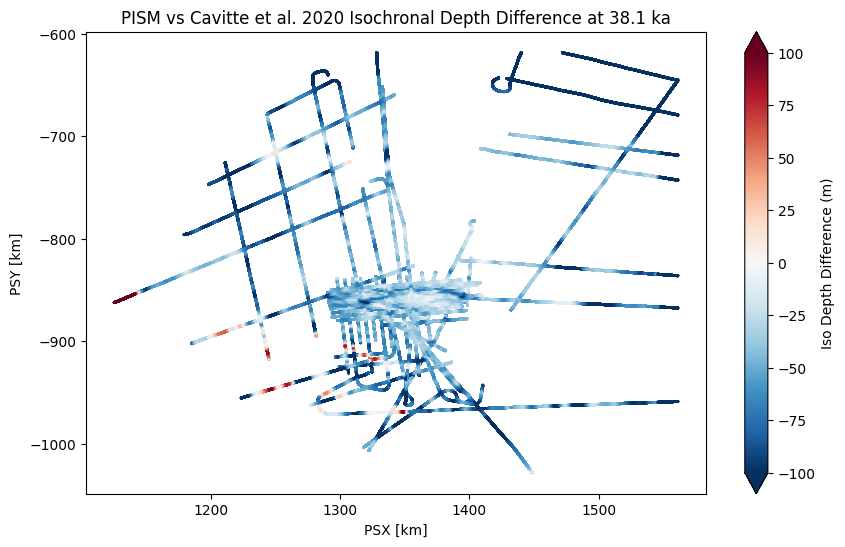

In [7]:
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame({
    'PSX': all_psx,
    'PSY': all_psy,
    'Depth_diff': all_depth_diff
})

plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df['PSX']/1000,
    df['PSY']/1000,
    c=df['Depth_diff'],
    cmap='RdBu_r',
    s=1,
    vmin=-100,
    vmax=100
)
plt.colorbar(sc, label='Iso Depth Difference (m)', extend='both')
plt.title('PISM vs Cavitte et al. 2020 Isochronal Depth Difference at 38.1 ka')
plt.xlabel('PSX [km]')
plt.ylabel('PSY [km]')
plt.show()

# 1D Transect mismatch 

It is also useful to simply plot the absolute isochronal layer depth in both PISM and the dataset as well as respective bed resolutions.
First we select a specific transect:

In [9]:
db.query(dataset='Cavitte_2020', flight_id='DC_LDC_DIVIDE')

f = db.get_files()[0] 
irh = xr.open_dataset(f, engine='h5netcdf')

We select a few layers we want to plot for comparison (one can plot everything, but here there is a lot)

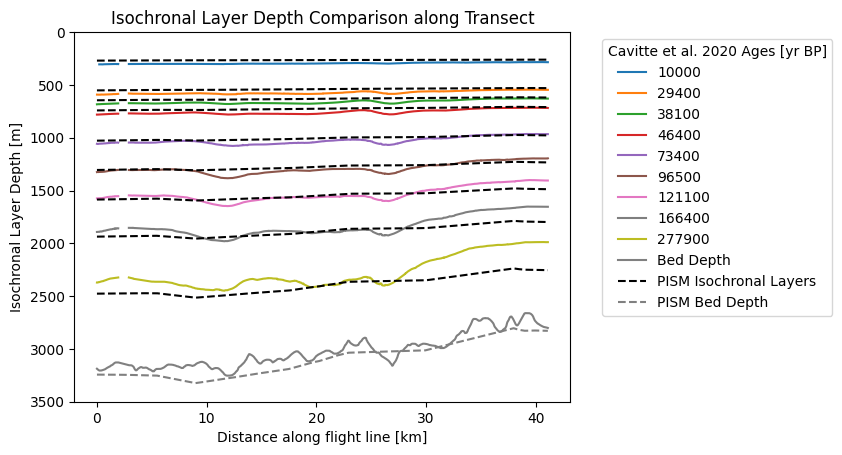

In [26]:
cavitte_ages = [10000, 29400, 38100, 46400, 73400, 96500, 121100, 166400, 277900]
irh_layers = irh.sel(IRH_AGE=cavitte_ages)
fl_line_xy = np.column_stack((irh.PSX, irh.PSY))

pism_ages = [10000, 29300, 38000, 46600, 73100, 97400, 122800, 165200, 278000] # PISM ages differ slightly since I used a different ice core chronology for the dating than in the original Cavitte et al. 2020 paper
pism_layers = pism_out.isochronal_layer_depth.sel(deposition_time=-(np.array(pism_ages)+age_offset)*3600*24*365)

plt.plot(irh.Distance/1000, irh_layers.IRH_DEPTH, label=irh_layers.IRH_AGE.values)
plt.plot(irh.Distance/1000, irh_layers.ICE_THK, color='gray', label='Bed Depth')

for age in pism_layers.deposition_time.values:
    pism_layer = pism_layers.sel(deposition_time=age).values.flatten()
    pism_depth_interp = griddata(pism_points, pism_layer, fl_line_xy, method='linear')
    plt.plot(irh.Distance/1000, pism_depth_interp, linestyle='--', color='k')
plt.plot(0,0, color='black', linestyle='--', label='PISM Isochronal Layers')    

pism_bed_depth_interp = griddata(pism_points, pism_out.thk.values.flatten(), fl_line_xy, method='linear')
plt.plot(irh.Distance/1000, pism_bed_depth_interp, color='gray', linestyle='--', label='PISM Bed Depth')    

plt.ylim(3500, 0)
plt.xlabel('Distance along flight line [km]')
plt.ylabel('Isochronal Layer Depth [m]')
plt.title('Isochronal Layer Depth Comparison along Transect')
plt.legend(title='Cavitte et al. 2020 Ages [yr BP]', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


